In [ ]:
from typing import TypeVar, Generic, Optional, Iterable
from abc import ABC, abstractmethod
from dataclasses import dataclass
import numpy as np
import itertools
import matplotlib.pyplot as plt

from rl.distribution import Distribution, Categorical, Constant
from rl.gen_utils.common_funcs import get_unit_sigmoid_func

First we create an abstract class MarkovProcess over a generic state space S. MarkovProcess has an abstract method called "transition" that specifies the transition matrix as well as another method "is_terminal" to query if a given state is a terminal state. Lastly, it has a method called "simulate" that enables us to generate a sequence of sampled states starting from a specified initial distribution. Note that this method calls upon the "sample" method which is specified in the Distribution class (from rl.distribution).

In [ ]:
S = TypeVar('S') #S can be anything (defined as type variable)

class MarkovProcess(ABC, Generic[S]):
    
    #define the abstract method "transition" of the abstract class "Markov Process" as taking the current state S and giving a distribution of states
    #This is defining the 1-step transition matrix of the Markov Chain 
    @abstractmethod
    def transition(self, state: S) -> Optional[Distribution[S]]: #Optional[x] means union of x and 'None'
        pass

    #check for terminal states, which do not have a transition matrix (equal to None)
    def is_terminal(self, state :S) -> bool:
        return self.transition(state) is None

#define a generic simulate function that accepts an initial distribution of states and outputs a new state in an iterated fashion
    def simulate(self, start_state_distribution: Distribution[S]) -> Iterable[S]:
        state : S = start_state_distribution.sample() #sample from the initial distribution to get starting state
    
        #iterate each time simulate is called
        while True:
            yield state
            next_states = self.transition(state) #new distribution of states
            if next_states is None:
                return

            #select a new state from the new distribution, this state will be used in the next iteration when simulate is called again.
            state = next_states.sample() 

Now we would like to use this abstract class to generate a concrete class for a real-world Markov Process. We do this by defining a new concrete class as a subclass of the abstract "Markov Process" class.

For this example, let's look at stock price transitions dictated by the sum of up moves and down moves input into a unit sigmoid to calculate the up probability.

In [3]:
#first, let's define our state which consists of the sum of up moves and down moves that have been executed
@dataclass(frozen=True)
class StateMP3:
    num_up_moves: int
    num_down_moves: int

#now let's define our concrete Markov Process
@dataclass
class StockPriceMP3(MarkovProcess[StateMP3]):
    alpha: float = 1 #strength of reversal to mean
    
    #define the probability of an up-move
    def up_prob(self, state: StateMP3) -> float:
        total = state.num_up_moves + state.num_down_moves #total moves
        return get_unit_sigmoid_func(self.alpha)(state.num_down_moves/total) if total else 0.5
    
    #define the transition matrix to two possible states (either after a step up or a step down) with their probabilities
    def transition(self, state: StateMP3) -> Categorical[StateMP3]:
        up_p = self.up_prob(state)
    
        return Categorical({StateMP3(state.num_up_moves + 1, state.num_down_moves): up_p,
             StateMP3(state.num_up_moves, state.num_down_moves + 1): (1 - up_p)})

At last, let's generate some sampling traces with our new class! Note that in the above, even though we specified the abstract method "transition" in the MarkovProcess class, we still need to specify it in the concrete class "StockPriceMP3" since we used "pass" in the abstract method.

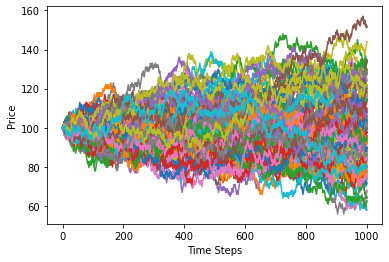

(array([ 3.,  8., 15., 18., 17., 14., 10.,  9.,  4.,  2.]),
 array([ 58. ,  67.4,  76.8,  86.2,  95.6, 105. , 114.4, 123.8, 133.2,
        142.6, 152. ]),
 <a list of 10 Patch objects>)

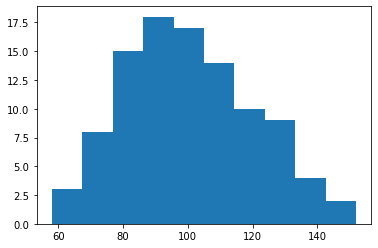

In [7]:
#let's define a function to collect the sampling traces
def process3_price_traces(start_price: int, alpha: float,time_steps: int, num_traces: int) -> np.ndarray:
    
    #set the markov process
    mp = StockPriceMP3(alpha = alpha)
    
    #generate the start state distribution
    start_state_distribution : Categorical = Constant(StateMP3(num_up_moves = 0, num_down_moves = 0))
    
    return np.vstack([np.fromiter(
        (start_price + s.num_up_moves - s.num_down_moves for s in itertools.islice(
        mp.simulate(start_state_distribution), time_steps + 1)),
        float) for _ in range(num_traces)])

start_price = 100
alpha = 1
time_steps = 1000
num_traces = 100

traces = process3_price_traces(start_price,alpha,time_steps,num_traces)

#Plot all of the traces together
for i in range(num_traces):
    plt.plot(traces[i,:])

plt.ylabel('Price')
plt.xlabel('Time Steps')
plt.show()

#plot the distribution of terminal prices
plt.hist(traces[:,-1])